In [ ]:
"""
Anh Huynh
Francisco Rivera 
Aster Lee
Andrew Bae
<other names>
"""


'\nAnh Huynh\nFrancisco Rivera \nAster Lee\nAndrew Bae\n<other names>\n'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

data = pd.read_csv('/content/drive/My Drive/456FinalProject/AirQualityUCIv2.csv', na_values='-200')

Box Plot

Text(0.5, 0.98, 'Nitrous Oxide concentrations (ppb) by hourly times')

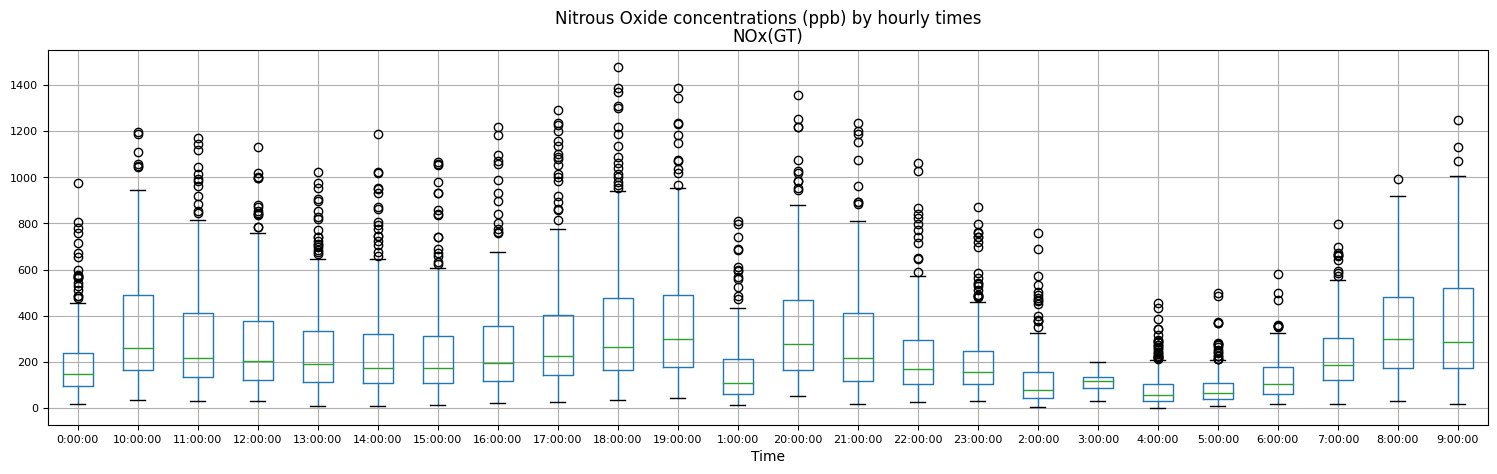

In [ ]:
nox_by_time = data.boxplot(column="NOx(GT)", by="Time", figsize=(18, 5), fontsize=8)
nox_by_time.get_figure().suptitle("Nitrous Oxide concentrations (ppb) by hourly times")

Histogram

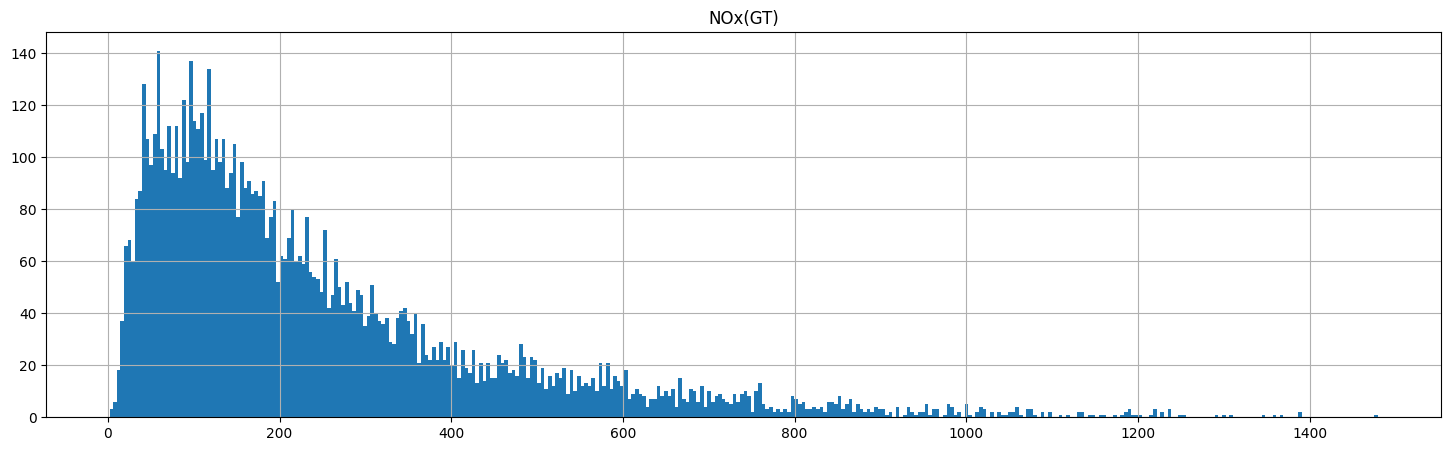

In [ ]:
nox_hist = data.hist(column="NOx(GT)", figsize=(18, 5), bins=350)

Line plot

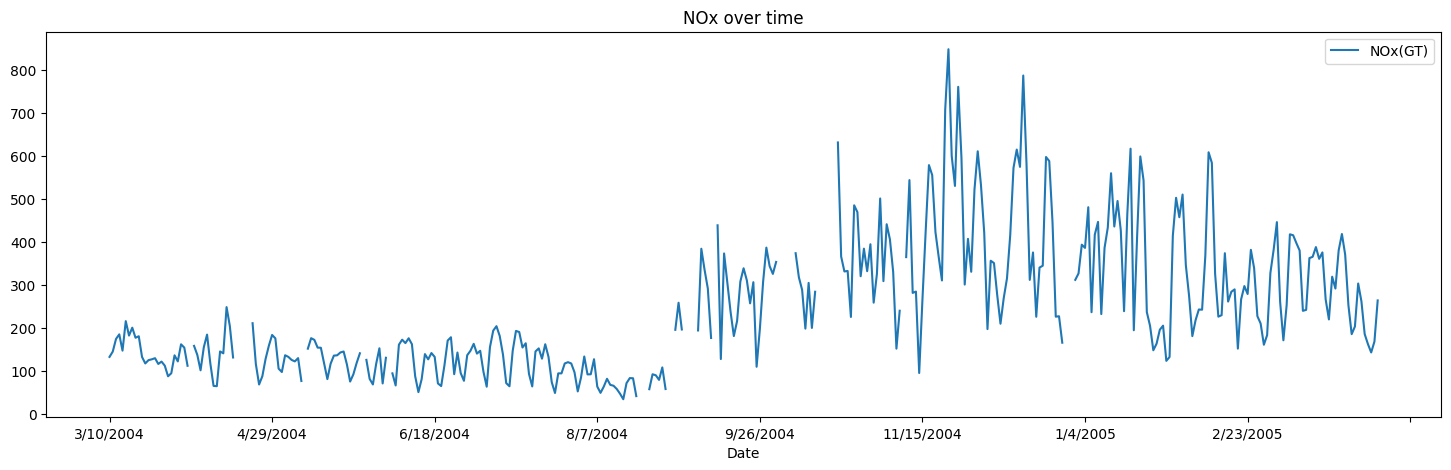

In [ ]:
nox_dated = data.groupby("Date", dropna=True)["NOx(GT)"].mean()
nox_dated = pd.DataFrame(nox_dated).sort_values(by="Date", key=lambda series: series.apply(lambda x: datetime.strptime(x, '%m/%d/%Y')))
nox_line = nox_dated.plot(title="NOx over time", figsize=(18, 5))

PCA

Column Titles: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Time_seconds']
Number of Components: 9

PCA Explained Variance: [0.56131562 0.18293693 0.11898368 0.05287979 0.03802036 0.01304922
 0.01072676 0.00752536 0.00705882]


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Text(0, 0.5, 'Second principle component')

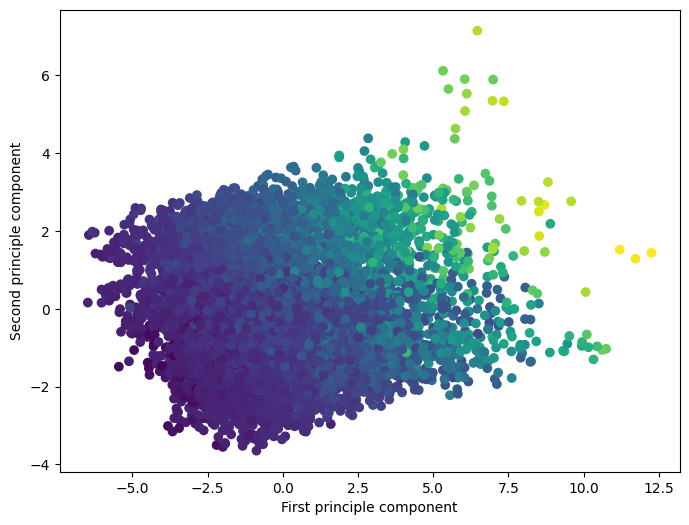

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


#turns data into a dataframe
#data2 = data.drop('NOx(GT)', axis=1)
df = pd.DataFrame(data)
#df = df.iloc[:, 2:15]
df = df.iloc[:, 1:15]

#included time to data set(Not Sure if this should be added)
df['Time_seconds'] = pd.to_timedelta(df['Time']).dt.total_seconds()
df = df.drop(columns=['Time'])

#Replacing NaN values with mean(Required since PCA does not deal with missing values)
#imputer = SimpleImputer(strategy='mean') #NOT GOOD TOO GENERAL
#imputer = KNNImputer(n_neighbors=10) #Better
#MICE Imputer
imputer = IterativeImputer() #Best

df = pd.DataFrame(imputer.fit_transform(df), columns = imputer.get_feature_names_out())
X = df.drop('NOx(GT)', axis=1)
y = df['NOx(GT)']

#Split Data into Training and Testing Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'Column Titles: {X_train.columns.tolist()}')
#print(df.loc[34])

#normalizes training and testing data
scaler = StandardScaler()
scaler.fit(X_train)
scaled_data = scaler.transform(X_train)
test_scaled_data = scaler.transform(X_test)

#print(scaled_data)

#Conducting PCA (Not on Target Values)
#pca = PCA(n_components = 13)
pca = PCA(.99) #setting the desired amount of variance to be retained
pca.fit(scaled_data)
print(f'Number of Components: {pca.n_components_}')
X_pca = pca.transform(scaled_data)
X_test_pca = pca.transform(test_scaled_data)
#displays the shape of the array
print(flush='PCA Shape: {X_pca.shape}')
#print(X_pca)
print(f'PCA Explained Variance: {pca.explained_variance_ratio_}')

#Visual Representation of PCA with target N0x
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_train)
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

K-Folds Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

model = LinearRegression()
model.fit(X_pca, y_train)
scores = cross_val_score(model, X_pca, y_train, cv = 5, scoring='r2')
print(f'r2 scores: {scores}')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

prediction = model.predict(X_test_pca)
MSE = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)
print(f'Mean Squared Error: {MSE}')
print(f'r2 Score: {r2}')

r2 scores: [0.88714897 0.89283491 0.88149084 0.88853942 0.88325379]
Accuracy: 0.89 (+/- 0.01)
Mean Squared Error: 4961.017859694137
r2 Score: 0.8866427693348029


Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

#Instantiating the different models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net Regression': ElasticNet(),
    'Bayesian Ridge Regression': BayesianRidge(),
    'Huber Regressor': HuberRegressor()
}

#Establishing which params we are going to perform hyperparameter Tuning
params = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Lasso Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10]},
    'Elastic Net Regression': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'Bayesian Ridge Regression': {'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 'alpha_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2], 'lambda_2': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]},
    'Huber Regressor': {'epsilon': [1.25, 1.5, 1.75], 'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
}

#specifying the metric to use for evaluating the performance of the models
#scoring_value = make_scorer(mean_squared_error, greater_is_better=False)

#Goes through each model and tests which param produces the most accurate score
for name, model in models.items():
    print(f'Tuning hyperparameters for {name}')
    grid_search = GridSearchCV(model, params[name], cv=5, return_train_score=False)
    grid_search.fit(X_pca, y_train)
    print(f'Best hyperparameters: {grid_search.best_params_}')
    print(f'Train MSE: {mean_squared_error(y_train, grid_search.predict(X_pca))}')
    print(f'Test MSE: {mean_squared_error(y_test, grid_search.predict(X_test_pca))}')
    print(f'r2 score: {r2_score(y_test, prediction)}')
    print(f'Best Score: {grid_search.best_score_} \n')


Tuning hyperparameters for Linear Regression
Best hyperparameters: {}
Train MSE: 4797.077431757428
Test MSE: 4961.017859694137
r2 score: 0.8866427693348029
Best Score: 0.8866535859378744 

Tuning hyperparameters for Ridge Regression
Best hyperparameters: {'alpha': 1}
Train MSE: 4797.0859195561825
Test MSE: 4960.913027225833
r2 score: 0.8866427693348029
Best Score: 0.886654360343295 

Tuning hyperparameters for Lasso Regression
Best hyperparameters: {'alpha': 0.01}
Train MSE: 4797.081318475469
Test MSE: 4960.953762849582
r2 score: 0.8866427693348029
Best Score: 0.8866536122848523 

Tuning hyperparameters for Elastic Net Regression
Best hyperparameters: {'alpha': 0.001, 'l1_ratio': 0.7}
Train MSE: 4797.111296528907
Test MSE: 4960.825958441275
r2 score: 0.8866427693348029
Best Score: 0.8866544978365832 

Tuning hyperparameters for Bayesian Ridge Regression
Best hyperparameters: {'alpha_1': 1e-06, 'alpha_2': 0.01, 'lambda_1': 0.01, 'lambda_2': 0.01}
Train MSE: 4797.0853488789235
Test MSE: 